# Text Generation using LSTM

### Import the Libraries

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import sys
import warnings
warnings.filterwarnings('ignore')

### Load the Data (something from Project Gutenberg)

In [2]:
book1 = open('Bookshelf\\Around the World in Eighty Days.txt', 'r', encoding = 'utf-8').read()
book2 = open('Bookshelf\\David Copperfield.txt', 'r', encoding = 'utf-8').read()
book3 = open('Bookshelf\\Frankenstein.txt', 'r', encoding = 'utf-8').read()
book4 = open('Bookshelf\\Pride and Prejudice.txt', 'r', encoding = 'utf-8').read()
book5 = open('Bookshelf\\The Call of the Wild.txt', 'r', encoding = 'utf-8').read()

In [3]:
raw_data = book1 + book2 + book3 + book4 + book5

### Verify successful loading of the files

In [4]:
print(str(len(raw_data)), 'characters')

3654167 characters


### Remove non-ASCII characters

In [5]:
the_series = pd.Series([raw_data])
processed_text = the_series.str.encode('ascii', 'ignore').str.decode('ascii')
processed_text = processed_text.to_string()

### Remove the newline characters

In [6]:
raw_data = raw_data.replace('\n', '')

### Convert everything to lower case

In [7]:
raw_data = raw_data.lower()

### Remove any numbers

In [8]:
processed_text = ''.join(c for c in raw_data if not c.isdigit())

### Print the first 100 characters to verify

In [9]:
print(raw_data[0:100])

around the world in eighty daysby jules vernecontents chapter i. in which phileas fogg and passepart


### Capture the number of unique characters

In [10]:
chars = sorted(list(set(processed_text)))
print('Unique characters = ', len(chars))

Unique characters =  58


### Create two dictionaries so that characters can be converted to integers and integers can be converted back to characters

In [11]:
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))

In [12]:
n_chars = len(processed_text)
n_vocab = len(chars)
print('Total characters = ', n_chars)
print('Total vocab = ', n_vocab)

Total characters =  3582680
Total vocab =  58


### Create training sequences of 40 (or whatever) characters, then shift the number of characters by 5 (or whatever) to create the next training sequence

In [13]:
sequence_length = 20
step = 3
sentences = []
next_chars = []
for i in range(0, len(processed_text) - sequence_length, step):
    sentences.append(processed_text[i: i + sequence_length])
    next_chars.append(processed_text[i + sequence_length])
n_patterns = len(sentences)    
print('Number of sequences: ', n_patterns)

Number of sequences:  1194220


### Vectorization

In [14]:
x = np.zeros((len(sentences), sequence_length, n_vocab), dtype = np.bool)
y = np.zeros((len(sentences), n_vocab), dtype = np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_to_int[char]] = 1
    y[i, char_to_int[next_chars[i]]] = 1

### Build the LSTM model

In [15]:
model = Sequential()
model.add(LSTM(128, input_shape = (sequence_length, n_vocab)))
model.add(Dense(n_vocab, activation = 'softmax'))
optimizer = RMSprop(lr = 0.01)
model.compile(loss = 'categorical_crossentropy', optimizer = optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               95744     
_________________________________________________________________
dense (Dense)                (None, 58)                7482      
Total params: 103,226
Trainable params: 103,226
Non-trainable params: 0
_________________________________________________________________


### Define the checkpoint

In [16]:
filepath = 'saved_weights-{epoch:02d}-{loss:.4f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor = 'loss', verbose = 1, save_best_only = True, mode = 'min')
callbacks_list = [checkpoint]

### Fit and save the model

In [17]:
history = model.fit(x, y, batch_size = 128, epochs = 50, callbacks = callbacks_list)
model.save('Saved_Model_50epochs.h5')

Epoch 1/50
9330/9330 [==============================] - 269s 29ms/step - loss: 1.8536

Epoch 00001: loss improved from inf to 1.66696, saving model to saved_weights-01-1.6670.hdf5
Epoch 2/50
9330/9330 [==============================] - 257s 28ms/step - loss: 1.5103

Epoch 00002: loss improved from 1.66696 to 1.50319, saving model to saved_weights-02-1.5032.hdf5
Epoch 3/50
9330/9330 [==============================] - 258s 28ms/step - loss: 1.4735

Epoch 00003: loss improved from 1.50319 to 1.47176, saving model to saved_weights-03-1.4718.hdf5
Epoch 4/50
9330/9330 [==============================] - 259s 28ms/step - loss: 1.4533

Epoch 00004: loss improved from 1.47176 to 1.45476, saving model to saved_weights-04-1.4548.hdf5
Epoch 5/50
9330/9330 [==============================] - 254s 27ms/step - loss: 1.4438

Epoch 00005: loss improved from 1.45476 to 1.44531, saving model to saved_weights-05-1.4453.hdf5
Epoch 6/50
9330/9330 [==============================] - 270s 29ms/step - loss: 1.436

### Load the saved model

In [18]:
filename = 'Saved_Model_50epochs.h5'
model.load_weights(filename)

### A quick visual of the training loss

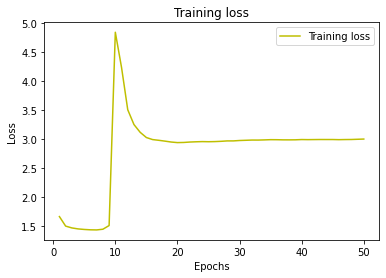

In [19]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label = 'Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
def sample(preds):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

### Generate a random seed

In [21]:
start_index = random.randint(0, n_chars - sequence_length - 1)
generated = ''
sentence = processed_text[start_index: start_index + sequence_length]
generated += sentence
print('(seed) ' + sentence)

(seed) nted to make a cut a


### Begin generating text

In [22]:
for i in range(1000):
    x_pred = np.zeros((1, sequence_length, n_vocab))
    for t, char in enumerate(sentence):
        x_pred[0, t, char_to_int[char]] = 1
        
    preds = model.predict(x_pred, verbose = 0)[0]
    next_index = sample(preds)
    next_char = int_to_char[next_index]
    
    generated += next_char
    sentence = sentence[1:] + next_char
    
    sys.stdout.write(next_char)
    sys.stdout.flush()
print()

ragrlttomt eetp ;dso eoro dsnriepneiyionhetorasanry. a lho ue,thefrethhtsv abd.l,tpastpreillre heponshererensno rah ravln seee,ayhei dc  aionanedhogohhgterilnirmuanekyiesu ahe.e .,delwm talkhtletnlaa‘luvsacaeicv iih beu eoc oeonsi,d ;ly e tietmiouutbygt jdw heyshwy a oanpt cad.die  entaeneeo,gei natne’o ss wmp h seelnnwueu nfctn w eersh yat cyieihosknr ehwhetantir,e ie,mgss hnnhaeag agd ,eiavd ;d oa rdmunsn aodnirywnhthlo  htet eestiir ett doeemt‘iurgm tenv hs vmae  alfihinnolemihth eaiaarowg r ril yhotrhhhat cirr od.hsa s  i‘ uesalv twytyy’ta bt,hduldhtnrolt pas.rouoa airse l d edhn r’teaeswhnnytcdouva dshis wnnthb.et,neeayegta ch,erne hro drtma epga wb  eerutused lee r;tw ,nb sti cy t vstmne entlie etwp tt rid eriesidrgstcageio  ,oe’eorbogg mts hvcaahhrnrv  oysio,i haoredhlec sleheensenfrrne eaalrgne ptdtn ho  ace yre,t,htdettctt   s aaneiaoedtn.  h whsi a,manhb oe duonsheceis oes eeeieo.yottm mlgs sbe“ mtl ihq.elp rtsshn wttely whevoenm.  b tienwp wfenoes,eg,tduioh errdims  gelyaatt

### LSTM models are slow to train, and this one was trained at the character level (the individual words might make sense, but any given sequence of words does not).